In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
# Set the path to dataset
dataset_path = '../images/3regimes/'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':2}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# Set the input image dimensions
img_width, img_height = 800, 800
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

def data_generation(list_IDs_temp):
    y = np.empty((len(list_IDs_temp)), dtype=int)
    X = []
    for i, ID in enumerate(list_IDs_temp):
        img= cv2.imread(ID)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H_val,S_val,V_val = img[:,:,0],img[:,:,1],img[:,:,2]
        # Extract the mean values of hue, saturation, and value
        H_mean = np.mean(H_val)
        S_mean = np.mean(S_val)
        V_mean = np.mean(V_val)
        # Extract the standard deviation of hue, saturation, and value
        H_std = np.std(H_val)
        S_std = np.std(S_val)
        V_std = np.std(V_val)
        # Extract the contrast values of hue, saturation, and value
        # H_max,S_max,V_max = np.max(H_val),np.max(S_val),np.max(V_val)
        # H_min,S_min,V_min = np.min(H_val),np.min(S_val),np.min(V_val)
        # H_contrast = (H_max - H_min) / (H_max + H_min)
        # S_contrast = (S_max - S_min) / (S_max + S_min)
        # V_contrast = (V_max - V_min) / (V_max + V_min)
        X.append([H_mean,H_std,S_mean,S_std,V_mean,V_std])
        y[i] = labels[ID]
    return pd.DataFrame(X,columns=['H_mean','H_std','S_mean','S_std','V_mean','V_std']),keras.utils.to_categorical(y, num_classes=params['n_classes']),y

In [2]:
X,y_categorical,y = data_generation(ids)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# Nombre de plis pour la validation croisée k-fold
k = 5

# Créer une instance de StratifiedKFold avec k plis
skf = StratifiedKFold(n_splits=k)


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
results = {i:{} for i in range(k)}

# Initialize a list to store the accuracy scores
accuracy_scores = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    # Diviser les données d'entraînement et de validation pour ce pli
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]

    y_train, y_val = y[train_index], y[test_index]

    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)

    for n_components in range(1,7):

        # Effectuer l'analyse en composantes principales (PCA)
        pca = PCA(n_components=n_components)  # Réduire le nombre de dimensions à 5
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)


        # Train the SVM classifier on the training data
        # Create a new instance of the SVM classifier for each fold
        svm_classifier = SVC()
        svm_classifier.fit(X_train_pca, y_train)

        y_val_pred = svm_classifier.predict(X_val_pca)

        # Calculate the accuracy score
        accuracy = metrics.accuracy_score(y_val, y_val_pred)

        # Obtenir les composantes principales
        components = pca.components_
        # Append the accuracy score to the list
        print(f'fold : {i}, n_components : {n_components}, val_accuracy : {accuracy}')
        accuracy_scores.append(accuracy)
        # Obtenir les composantes principales et les valeurs propres
        components = pca.components_
        explained_variance = pca.explained_variance_

        # Afficher les composantes principales dans l'ordre d'importance
        for i, component in enumerate(components):
            importance = explained_variance[i]
            print("Composante", i+1, "- Importance:", importance)
            for j, weight in enumerate(component):
                print("Poids", j+1, ":", weight)
            print()
    
# Compute the average accuracy across all folds
average_accuracy = sum(accuracy_scores) / k

# Print the average accuracy
print("Average Accuracy:", average_accuracy)

Fold 0:
  Train: index=[ 334  335  336 ... 5007 5008 5009]
  Test:  index=[   0    1    2 ... 3671 3672 3673]
fold : 0, n_components : 1, val_accuracy : 0.8542914171656687
Composante 1 - Importance: 2874.2696930148004
Poids 1 : 0.07291343427086756
Poids 2 : 0.09178023082394315
Poids 3 : 0.11151850204421226
Poids 4 : -0.05273261839036644
Poids 5 : 0.8211049204487858
Poids 6 : 0.5448207270350829

fold : 0, n_components : 2, val_accuracy : 0.8652694610778443
Composante 1 - Importance: 2874.2696930148004
Poids 1 : 0.07291343427086762
Poids 2 : 0.09178023082394293
Poids 3 : 0.11151850204421226
Poids 4 : -0.05273261839036644
Poids 5 : 0.8211049204487859
Poids 6 : 0.5448207270350828

Composante 2 - Importance: 14.678516752262716
Poids 1 : -0.15095445042542285
Poids 2 : -0.1771702161297332
Poids 3 : 0.2396074082831169
Poids 4 : 0.3595270814526398
Poids 5 : -0.4651065827041717
Poids 6 : 0.7367685543890596

fold : 1, n_components : 3, val_accuracy : 0.8602794411177644
Composante 1 - Importance: 

C:\Users\nrozo\AppData\Local\Temp\ipykernel_13112\1627178531.py:14: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c='gray', marker='x', edgecolor='k', label='Validation')


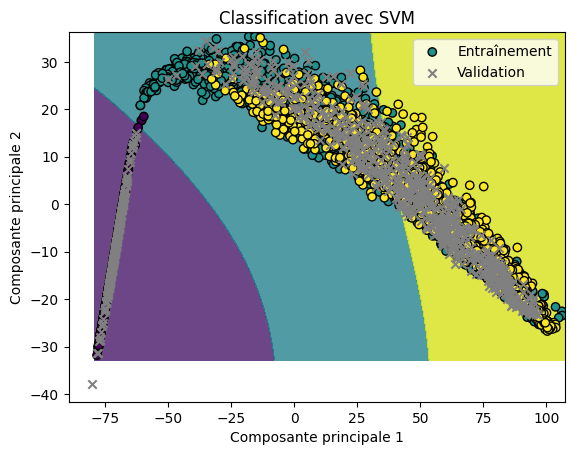

In [26]:
# # Tracer les données d'entraînement et de validation ainsi que les frontières de décision
# x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
# y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
# Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)


# plt.figure()
# plt.contourf(xx, yy, Z, alpha=0.8)

# # Tracer les échantillons de validation en utilisant des marqueurs distincts
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', label='Entraînement')
# plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c='gray', marker='x', edgecolor='k', label='Validation')

# plt.xlabel('Composante principale 1')
# plt.ylabel('Composante principale 2')
# plt.title('Classification avec SVM')
# plt.legend()
# plt.show()

C:\Users\nrozo\AppData\Local\Temp\ipykernel_13112\2827222929.py:3: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c='gray', marker='x', edgecolor='k', label='Validation')


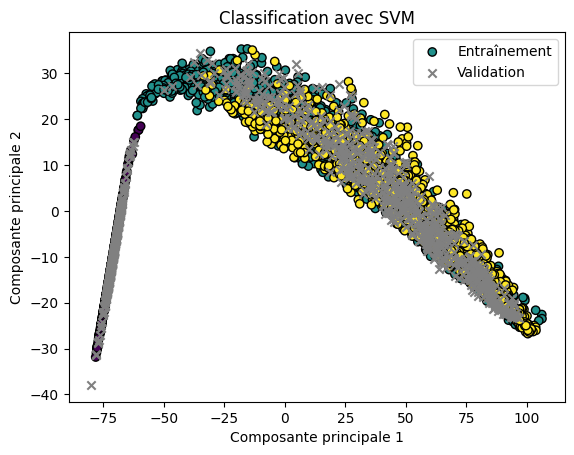